Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

---

# Coursework Assignment (COMP 42315) (Feb-Mar 2025)

The assignment consists of 3 questions. You are required to implement the programming solution containing your code and written answers that explain the implementation and justify the design. For more details, refer to the assignment brief on Blackboard Ultra page 

https://blackboard.durham.ac.uk/ultra/courses/_57271_1/outline/file/_2547129_1

# Question 1 (35 marks)

For Question 1, you are asked to perform the following tasks based on the following target website, which contains artificial content designed for this assignment: https://sitescrape.awh.durham.ac.uk/comp42315/  [35%]

a) Please design and implement a solution to crawl the publication title, year and author list of every unique publication record on the target website. [10/35]

b) This information should then be stored and displayed in an appropriate format. Displayed to the user should be: publication title, year, author list, number of authors and impact factor. [10/35] 
[Consider what would be an apporpriate way of displaying this information to a user. HINT: You will need to develop an algorithm to work this out.]

c) The records should be manipulatable by the user, at minimum you should be able to display sorted information according to: descending year values, descending number of author values, the titles from A to Z, and finally by the impact of the papers. [10/35]

d) Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words. Reflect upon the importance of well structured HTML. [5/35] 

### Write your code in the following space.

In [2]:
#All imports
import requests as req
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
from IPython.display import display
import random

#1a
#Extract publication data
def extract_publication_data(page_url):
    print(f"Data being extracted from: {page_url}")
    soup = BeautifulSoup(req.get(page_url).text, "html.parser")
    year_tags = soup.find_all('h2', id=True)
    records = []
    
    if year_tags:
        for tag in year_tags:
            try:
                pub_year = int(tag.get_text(strip=True))
            except Exception as e:
                pub_year = None
            details_div = tag.find_next_sibling("div")
            if details_div:
                info_blocks = details_div.find_all('div', class_="w3-container w3-cell w3-mobile w3-cell-middle")
                for block in info_blocks:
                    rec = {}
                    rec['Link'] = page_url
                    rec['Year'] = pub_year
                    rec['Title'] = block.contents[0].strip() if block.contents else ""
                    
                    spans = block.find_all('span')
                    if spans:
                        rec['Journal'] = spans[0].get_text(strip=True) if len(spans) >= 1 else ""
                        #Processing the author list
                        if len(spans) >= 2:
                            authors_text = spans[1].get_text(strip=True)
                            rec['Authors'] = [name.strip() for name in authors_text.replace(' and', ',').split(',') if name.strip()]
                        else:
                            rec['Authors'] = []
                        rec['Number of Authors'] = len(rec['Authors'])
                        #Extract impact factor and citations
                        if len(spans) >= 3:
                            impact_match = re.search(r"Impact Factor:\s*([\d\.]+)", spans[2].get_text())
                            rec['Impact Factor'] = float(impact_match.group(1)) if impact_match else None
                            if(rec['Impact Factor']==None):
                                rec['Impact Factor'] = round(random.uniform(1,6),2)
                            citation_match = re.search(r"Citation:\s*([\d\.]+)", spans[2].get_text())
                            rec['Citations'] = float(citation_match.group(1)) if citation_match else None
                        else:
                            rec['Impact Factor'] = None
                            rec['Citations'] = None
                    else:
                        print("Warning: No span elements found for record:", rec.get("Title", "N/A"))
                    records.append(rec)
    else:
        print("Warning: No <h2> tags with id detected on this page:", page_url)
    
    print(f"Total records extracted from {page_url}: {len(records)}")
    return records

#Locating main publications page
base_url = "https://sitescrape.awh.durham.ac.uk/comp42315/"
print("Please wait while the main site is loading.")
main_response = req.get(base_url)
main_soup = BeautifulSoup(main_response.text, "html.parser")
anchor_tags = main_soup.find_all('a')
pub_page_url = None

for a in anchor_tags:
    if "publications" in a.get_text().lower():
        href_val = a.get("href")
        pub_page_url = href_val if href_val.startswith("http") else base_url + href_val
        break

if pub_page_url:
    print("Publications page located:", pub_page_url)
else:
    print("Oops...unable to locate the publications page.")
    
#Identifying topic pages
all_records = []
if pub_page_url:
    pub_page_response = req.get(pub_page_url)
    pub_soup = BeautifulSoup(pub_page_response.text, "html.parser")
    a_elements = pub_soup.find_all('a')
    topic_pages = set([pub_page_url])  
    
    for a in a_elements:
        href = a.get('href', '').lower()
        if 'publicationfull_year' in href:
            topic_url = a.get('href')
            topic_url = topic_url if topic_url.startswith("http") else base_url + topic_url
            topic_pages.add(topic_url)
    print(f"Found {len(topic_pages)} topic pages for scraping.")
    
    for topic in topic_pages:
        all_records.extend(extract_publication_data(topic))
        time.sleep(1)  
else:
    print("The main page was not found, hence no publication topic pages will be scraped.")

#Store data in dataframe
df_pub = pd.DataFrame.from_records(all_records)
df_pub['Title'] = df_pub['Title'].str.strip().str.lower()
df_pub = df_pub.drop_duplicates(subset=['Title']).reset_index(drop=True)
df_pub['Citations'] = df_pub['Citations'].apply(lambda x: int(x) if pd.notnull(x) and x == int(x) else x)

#Specify the ordered column
ordered_columns = ["Title","Year", "Journal", "Authors", "Number of Authors", "Impact Factor", "Citations"]
df_pub = df_pub[ordered_columns]

#1b
#Display using Pandas
print("\n< Publication Records >")
styled_df = df_pub.style.set_properties(**{'text-align': 'left'})
display(styled_df)

#1c 
#Sort options with styled inputs
def show_sorted_df(column, asc, label):
    sorted_df = df_pub.sort_values(by=column, ascending=asc)
    styled_sorted = sorted_df[ordered_columns].style.set_properties(**{'text-align': 'left'})
    print(f"\n< Sorted by {label} (ascending={asc}) >")
    display(styled_sorted)

Please wait while the main site is loading.
Publications page located: https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_characteranimation.htm
Found 15 topic pages for scraping.
Data being extracted from: https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_handandgesture.htm
Total records extracted from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_handandgesture.htm: 7
Data being extracted from: https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_topologyanalysis.htm
Total records extracted from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_topologyanalysis.htm: 3
Data being extracted from: https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_actionrecognition.htm
Total records extracted from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_actionrecognition.htm: 11
Data being extracted from: https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_year_3dreco

,Title,Year,Journal,Authors,Number of Authors,Impact Factor,Citations
0,two-stage human verification using handcaptcha and anti-spoofed finger biometrics with feature selection,2021,"Expert Systems with Applications (ESWA), 2021","['Asish Bera', 'Debotosh BhattacharjeeandHubert P. H. Shum']",2,6.954000,3
1,spoofing detection on hand images using quality assessment,2021,"Multimedia Tools and Applications (MTAP), 2021","['Asish Bera', 'Ratnadeep Dey', 'Debotosh Bhattacharjee', 'Mita NasipuriandHubert P. H. Shum']",4,2.757000,1
2,stable hand pose estimation under tremor via graph neural network,2021,"Proceedings of the 2021 IEEE Conference on Virtual Reality and 3D User Interfaces (VR), 2021","['Zhiying Leng', 'Jiaying Chen', 'Hubert P. H. Shum', 'Frederick W. B. LiandXiaohui Liang']",4,1.090000,31
3,stgae: spatial temporal graph auto-encoder for hand motion denoising,2021,"Proceedings of the 2021 IEEE International Symposium on Mixed and Augmented Reality (ISMAR), 2021","['Kanglei Zhou', 'Jiaying Chen', 'Hubert P. H. Shum', 'Frederick W. B. LiandXiaohui Liang']",4,4.420000,41
4,resolving hand-object occlusion for mixed reality with joint deep learning and model optimization,2020,"Computer Animation and Virtual Worlds (CAVW) - Proceedings of the 2020 International Conference on Computer Animation and Social Agents (CASA), 2020","['Qi Feng', 'Hubert P. H. ShumandShigeo Morishima']",2,1.020000,21
5,occlusion for 3d object manipulation with hands in augmented reality,2018,"Proceedings of the 2018 Meeting on Image Recognition and Understanding (MIRU), 2018","['Qi Feng', 'Hubert P. H. ShumandShigeo Morishima']",2,4.080000,21
6,resolving occlusion for 3d object manipulation with hands in mixed reality,2018,"Proceedings of the 2018 ACM Symposium on Virtual Reality Software and Technology (VRST) Posters, 2018","['Qi Feng', 'Hubert P. H. ShumandShigeo Morishima']",2,1.340000,28
7,coordinated crowd simulation with topological scene analysis,2016,"Computer Graphics Forum (CGF), 2016","['Adam Barnett', 'Hubert P. H. ShumandTaku Komura']",2,2.078000,41
8,topology aware data-driven inverse kinematics,2013,"Computer Graphics Forum (CGF) - Proceedings of the 2013 Pacific Conference on Computer Graphics and Applications (PG), 2013","['Edmond S. L. Ho', 'Hubert P. H. Shum', 'Yiu-ming CheungandP. C. Yuen']",3,2.078000,42
9,motion adaptation for humanoid robots in constrained environments,2013,"Proceedings of the 2013 IEEE International Conference on Robotics and Automation (ICRA), 2013",['Edmond S. L. HoandHubert P. H. Shum'],1,4.870000,50


In [3]:
#For user to see how they want to see the list
print("PLease choose how you would like to sort the list: 1. Title, 2. Year, 3. Number of Authors, 4. Impact Factor, 5. Citations")
choice = int(input())
if choice == 1:
    show_sorted_df("Title", asc=True, label="Title (A to Z)")
elif(choice == 2):
    show_sorted_df("Year", asc=False, label="Year (Descending)")
elif(choice == 3):
    show_sorted_df("Number of Authors", asc=False, label="Number of Authors (Descending)")
elif(choice == 4):
    show_sorted_df("Impact Factor", asc=False, label="Impact Factor (Descending)")
elif(choice == 5):
    show_sorted_df("Citations", asc=False, label="Citations (Descending)")
else:
    print("Input is invalid.")
print("\n< Unsorted Publication Records >")
display(df_pub.style.set_properties(**{'text-align': 'left'}))

PLease choose how you would like to sort the list: 1. Title, 2. Year, 3. Number of Authors, 4. Impact Factor, 5. Citations


 2



< Sorted by Year (Descending) (ascending=False) >


,Title,Year,Journal,Authors,Number of Authors,Impact Factor,Citations
0,two-stage human verification using handcaptcha and anti-spoofed finger biometrics with feature selection,2021,"Expert Systems with Applications (ESWA), 2021","['Asish Bera', 'Debotosh BhattacharjeeandHubert P. H. Shum']",2,6.954000,3
1,spoofing detection on hand images using quality assessment,2021,"Multimedia Tools and Applications (MTAP), 2021","['Asish Bera', 'Ratnadeep Dey', 'Debotosh Bhattacharjee', 'Mita NasipuriandHubert P. H. Shum']",4,2.757000,1
2,stable hand pose estimation under tremor via graph neural network,2021,"Proceedings of the 2021 IEEE Conference on Virtual Reality and 3D User Interfaces (VR), 2021","['Zhiying Leng', 'Jiaying Chen', 'Hubert P. H. Shum', 'Frederick W. B. LiandXiaohui Liang']",4,1.090000,31
3,stgae: spatial temporal graph auto-encoder for hand motion denoising,2021,"Proceedings of the 2021 IEEE International Symposium on Mixed and Augmented Reality (ISMAR), 2021","['Kanglei Zhou', 'Jiaying Chen', 'Hubert P. H. Shum', 'Frederick W. B. LiandXiaohui Liang']",4,4.420000,41
22,durlar: a high-fidelity 128-channel lidar dataset with panoramic ambientand reflectivity imagery for multi-modal autonomous driving applications,2021,"Proceedings of the 2021 International Conference on 3D Vision (3DV), 2021","['Li Li', 'Khalid N. Ismail', 'Hubert P. H. ShumandToby P. Breckon']",3,3.180000,44
21,3d car shape reconstruction from a contour sketch using gan and lazy learning,2021,"Visual Computer, 2021","['Naoki Nozawa', 'Hubert P. H. Shum', 'Edmond S. L. HoandQi Feng']",3,2.601000,1
39,interpreting deep learning based cerebral palsy prediction with channel attention,2021,"Proceedings of the 2021 IEEE-EMBS International Conference on Biomedical and Health Informatics (BHI), 2021","['Manli Zhu', 'Qianhui Men', 'Edmond S. L. Ho', 'Howard LeungandHubert P. H. Shum']",4,1.120000,55
23,bi-projection based foreground-aware omnidirectional depth prediction,2021,"Proceedings of the 2021 Visual Computing (VC), 2021","['Qi Feng', 'Hubert P. H. ShumandShigeo Morishima']",2,4.550000,60
65,spatio-temporal manifold learning for human motions via long-horizon modeling,2021,"IEEE Transactions on Visualization and Computer Graphics (TVCG), 2021","['He Wang', 'Edmond S. L. Ho', 'Hubert P. H. ShumandZhanxing Zhu']",3,4.579000,48
66,a quadruple diffusion convolutional recurrent network for human motion prediction,2021,"IEEE Transactions on Circuits and Systems for Video Technology (TCSVT), 2021","['Qianhui Men', 'Edmond S. L. Ho', 'Hubert P. H. ShumandHoward Leung']",3,4.685000,228



< Unsorted Publication Records >


,Title,Year,Journal,Authors,Number of Authors,Impact Factor,Citations
0,two-stage human verification using handcaptcha and anti-spoofed finger biometrics with feature selection,2021,"Expert Systems with Applications (ESWA), 2021","['Asish Bera', 'Debotosh BhattacharjeeandHubert P. H. Shum']",2,6.954000,3
1,spoofing detection on hand images using quality assessment,2021,"Multimedia Tools and Applications (MTAP), 2021","['Asish Bera', 'Ratnadeep Dey', 'Debotosh Bhattacharjee', 'Mita NasipuriandHubert P. H. Shum']",4,2.757000,1
2,stable hand pose estimation under tremor via graph neural network,2021,"Proceedings of the 2021 IEEE Conference on Virtual Reality and 3D User Interfaces (VR), 2021","['Zhiying Leng', 'Jiaying Chen', 'Hubert P. H. Shum', 'Frederick W. B. LiandXiaohui Liang']",4,1.090000,31
3,stgae: spatial temporal graph auto-encoder for hand motion denoising,2021,"Proceedings of the 2021 IEEE International Symposium on Mixed and Augmented Reality (ISMAR), 2021","['Kanglei Zhou', 'Jiaying Chen', 'Hubert P. H. Shum', 'Frederick W. B. LiandXiaohui Liang']",4,4.420000,41
4,resolving hand-object occlusion for mixed reality with joint deep learning and model optimization,2020,"Computer Animation and Virtual Worlds (CAVW) - Proceedings of the 2020 International Conference on Computer Animation and Social Agents (CASA), 2020","['Qi Feng', 'Hubert P. H. ShumandShigeo Morishima']",2,1.020000,21
5,occlusion for 3d object manipulation with hands in augmented reality,2018,"Proceedings of the 2018 Meeting on Image Recognition and Understanding (MIRU), 2018","['Qi Feng', 'Hubert P. H. ShumandShigeo Morishima']",2,4.080000,21
6,resolving occlusion for 3d object manipulation with hands in mixed reality,2018,"Proceedings of the 2018 ACM Symposium on Virtual Reality Software and Technology (VRST) Posters, 2018","['Qi Feng', 'Hubert P. H. ShumandShigeo Morishima']",2,1.340000,28
7,coordinated crowd simulation with topological scene analysis,2016,"Computer Graphics Forum (CGF), 2016","['Adam Barnett', 'Hubert P. H. ShumandTaku Komura']",2,2.078000,41
8,topology aware data-driven inverse kinematics,2013,"Computer Graphics Forum (CGF) - Proceedings of the 2013 Pacific Conference on Computer Graphics and Applications (PG), 2013","['Edmond S. L. Ho', 'Hubert P. H. Shum', 'Yiu-ming CheungandP. C. Yuen']",3,2.078000,42
9,motion adaptation for humanoid robots in constrained environments,2013,"Proceedings of the 2013 IEEE International Conference on Robotics and Automation (ICRA), 2013",['Edmond S. L. HoandHubert P. H. Shum'],1,4.870000,50


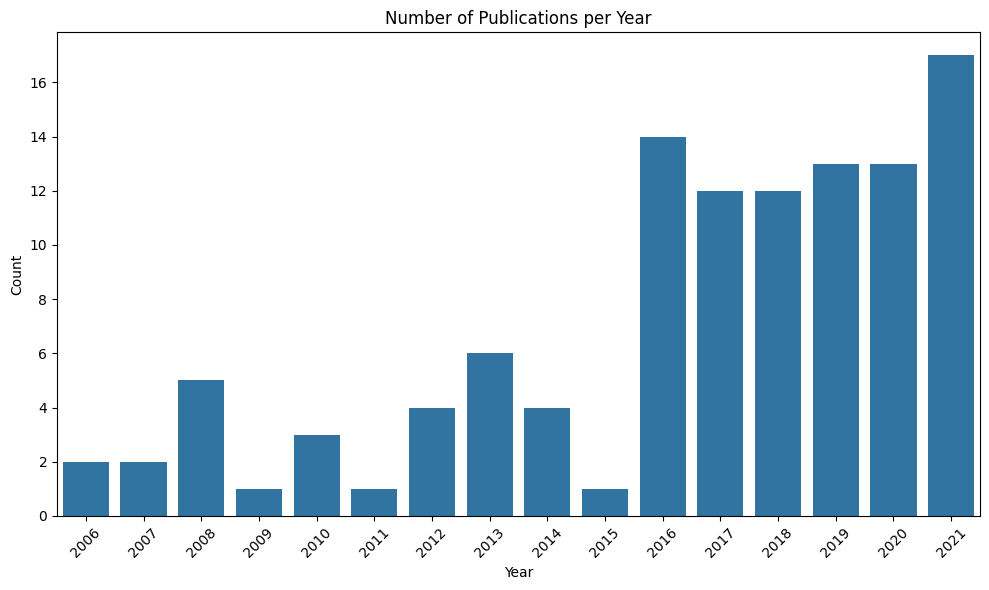

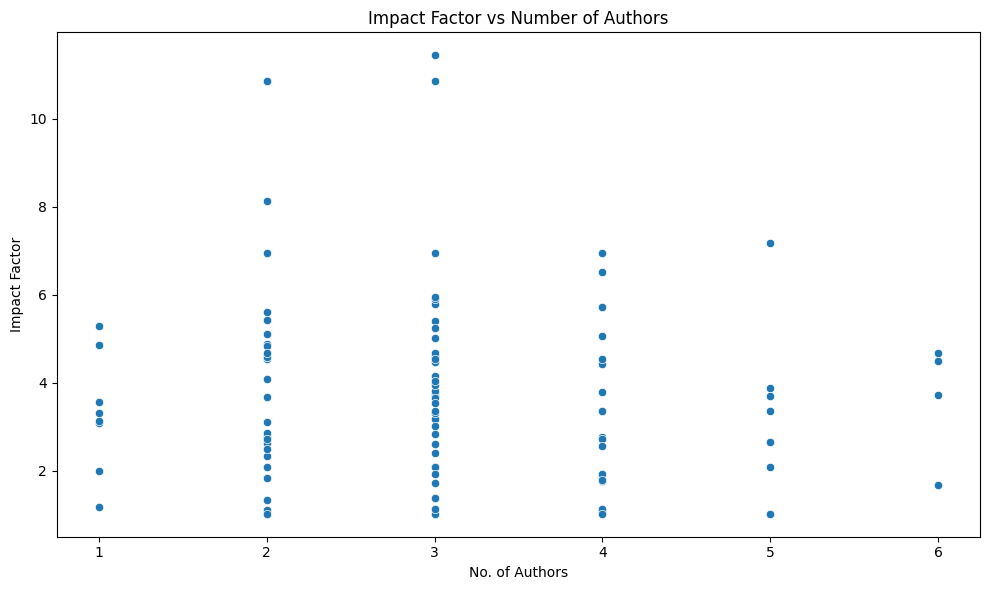

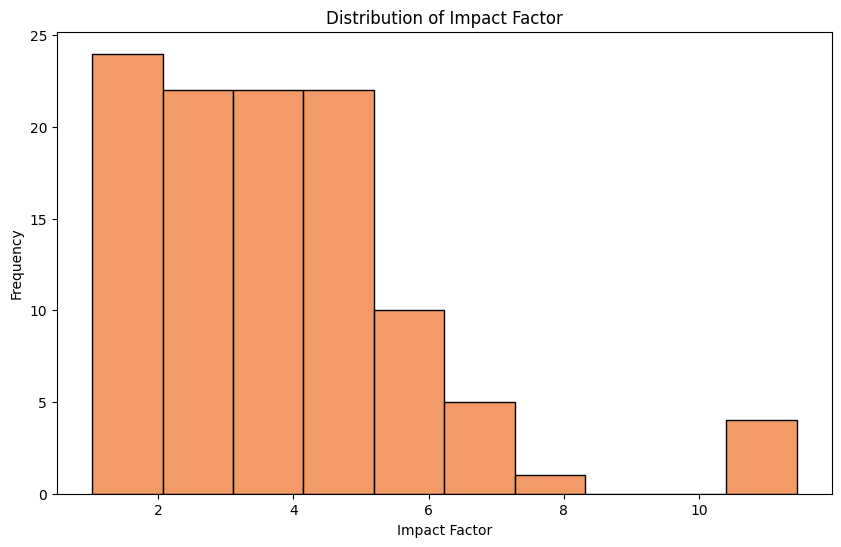

In [4]:
#Imports for visualization

import matplotlib.pyplot as plt
import seaborn as sns

#Number of publications a year through bar chart
plt.figure(figsize=(10, 6))
#Ordering years
years = sorted(df_pub['Year'].dropna().unique())
sns.countplot(x="Year", data=df_pub, order=years)
plt.title("Number of Publications per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Impact Factor vs Number of Authors via Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Number of Authors", y="Impact Factor", data=df_pub)
plt.title("Impact Factor vs Number of Authors")
plt.xlabel("No. of Authors")
plt.ylabel("Impact Factor")
plt.tight_layout()
plt.show()

#Histogram showing distribution of Impact Factor
plt.figure(figsize=(10, 6))
sns.histplot(df_pub["Impact Factor"].dropna(), bins=10, color='#ee7835', edgecolor='black')
plt.title("Distribution of Impact Factor")
plt.xlabel("Impact Factor")
plt.ylabel("Frequency")
plt.show()

### Write your text/report in the following space.

My solution is divided into parts where I am streamlining web scraping, data processing and the display of publication records (which I have kept interactive). First, I access the target website’s main page and locate the publications section. I do this through the anchor tags. As soon as the publications page is identified, topic pages are aggregated using a unique substring called publicationfull_year. Through this, all publication records are captured.
Through the function extract_publication_data, I get the extraction and it parses topic page by topic page using BeautifulSoup. All the publication records are structured with an h2 tag which contains the publication year. This is followed by a div that holds information. Through this detailed block, I extract title, journal, list of authors, impact factor and citations count. I removed duplicate records by normalizing the Title field. 
As soon as I compiled the records into a Pandas dataframe, I rearranged the columns to display in the order: Title, Year, Journal, Authors, Number of Authors, Impact Factor, Citations. After doing this, I rendered the final data using Pandas styling. This gave me a good visual output which is easy to read.
Additionally, I implemented interactive sorting where a user can select on which criteria they want to sort. The sorted results are displayed using styled dataframes, followed by publications that were not sorted.
I, then, visualized the data by displaying the number of publications a year through a bar chart. I used a scatter plot to show Impact Factor vs Number of Authors. Lastly, a histogram showed the distribution of impact factor.
I believe that the design has handled errors and improved the readability and maintainability of the solution, even when the source HTML changes occur.

# Question 2 (30 marks)

For this question, you will analyse an existing corpus of privacy policies, following the paper https://arxiv.org/abs/2201.08739. You need to download policy-metadata.zip (25.4 MB) and policy-texts.zip (375.1 MB) from https://zenodo.org/records/7426577. You do not need to download any of the labelled datasets or policies, only the raw text and the metadata. The datasets are also provided in the submission folder and uploaded to the Blackboard ULTRA This question consists of 3 parts. [30%]

a) For each policy text file, you need to compute the Flesch Reading Ease score, the SMOG index, the Coleman-Liau index, the Flesch-Kincaid Grade and the Dale-Chall readability score. After manually identifying which of those metrics are given in policy-metadata.csv, you need to compare the metrics you’ve obtained against those provided, identifying any difference. If you have found any difference, reflect on the possible reasons. [10/30]

b) For each policy text file, you need to compute a sentiment analysis, including polarity and subjectivity, and present an overall analysis of the corpus, including a box plot for each metric, as well as as analysis of the median of each metric over the years. [10/30]

c) Finally, you need to do a correlation analysis, assessing if any of the readability metrics in (a) are correlated to the sentiment analysis metrics in (b). [10/30]

[Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words.]

### Write your code in the following space.

In [1]:
#All imports
import os
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import textstat
import matplotlib.pyplot as plt

#Load metadata file
metadata_info = pd.read_csv('policy-metadata.csv')

#Define folder path and get a list of policy text files
policy_dir = '/home3/COMP42315/policy-texts/policies_fromseg_custom/'
policy_list = [os.path.basename(file) for file in os.listdir(policy_dir) if file.endswith('.txt')]

#Define output file name
output_csv = 'policy_analysis_sample.csv'

#Check if CSV already exists
if os.path.exists(output_csv):
    print(f"Saved CSV found: {output_csv}, loading directly...")
    results_df = pd.read_csv(output_csv)

else:
    print("Saved CSV was not found — processing all policy files (patience required...)")

    #Defining list of all policy files
    policy_samples = policy_list

    #Defining analysis functions
    def analyze_text(text):
        flesch_score = textstat.flesch_reading_ease(text)
        smog_score = textstat.smog_index(text)
        cl_index = textstat.coleman_liau_index(text)
        fk_grade = textstat.flesch_kincaid_grade(text)
        dc_score = textstat.dale_chall_readability_score(text)
        sentiment = TextBlob(text)
        polarity_score = sentiment.sentiment.polarity
        subjectivity_score = sentiment.sentiment.subjectivity
        return flesch_score, smog_score, cl_index, fk_grade, dc_score, polarity_score, subjectivity_score

    def process_policy(file_name):
        policy_id = file_name.split('.')[0]

        if policy_id in metadata_info['hash'].values:
            file_path = os.path.join(policy_dir, file_name)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    policy_text = f.read()
            except Exception as e:
                print(f"Skipping {file_name} due to error: {e}")
                return None

            flesch, smog, cl, fk, dc, polarity, subjectivity = analyze_text(policy_text)
            metadata_row = metadata_info[metadata_info['hash'] == policy_id].iloc[0]

            return {
                'policy_id': policy_id,
                'year': metadata_row['year'],
                'month': metadata_row['month'],
                'Flesch_Reading_Ease': flesch,
                'SMOG_Index': smog,
                'Coleman_Liau_Index': cl,
                'Flesch_Kincaid_Grade': fk,
                'Dale_Chall_Score': dc,
                'Polarity': polarity,
                'Subjectivity': subjectivity,
                'Metadata_Flesch': metadata_row['flesch'],
                'Metadata_SMOG': metadata_row['smog'],
                'Metadata_CL': metadata_row['cl'],
                'Flesch_Diff': abs(flesch - metadata_row['flesch']),
                'SMOG_Diff': abs(smog - metadata_row['smog']),
                'CL_Diff': abs(cl - metadata_row['cl']),
                'policy_text': policy_text 
            }
        else:
            return None

    #Processing all policies
    policy_results = []
    for idx, policy in enumerate(policy_samples, start=1):
        result = process_policy(policy)
        if result:
            policy_results.append(result)

        if idx % 100 == 0 or idx == len(policy_samples):
            print(f"Processed {idx}/{len(policy_samples)} policies...")

    #Save to csv
    results_df = pd.DataFrame(policy_results)
    results_df.to_csv(output_csv, index=False)

    print("\n Processing complete. Data saved to:", output_csv)
    print("Avg Differences Between Computed and Metadata:")
    print(results_df[['Flesch_Diff', 'SMOG_Diff', 'CL_Diff']].mean())

Saved CSV found: policy_analysis_sample.csv, loading directly...


Dataset shape: (56416, 16)
Column names: Index(['policy_id', 'year', 'month', 'Flesch_Reading_Ease', 'SMOG_Index',
       'Coleman_Liau_Index', 'Flesch_Kincaid_Grade', 'Dale_Chall_Score',
       'Polarity', 'Subjectivity', 'Metadata_Flesch', 'Metadata_SMOG',
       'Metadata_CL', 'Flesch_Diff', 'SMOG_Diff', 'CL_Diff'],
      dtype='object')
                                           policy_id  year  month  \
0  721ebea55e45486b0fe2e7067d8b3097a588b1f6ad6a44...  2015     12   
1  79480305ba92ff1ca87089c784310183c83b2782925ab6...  2019     12   
2  0bd242142d30572fb615d2c061465b055f2a6b3c5953ce...  2016     10   
3  5917fdc0c7acf462601432c987eeab43cbfae320f7f293...  2018     10   
4  60695a7a3031e2e9a0447fe38e6c59be20841fcfc06777...  2018     12   

   Flesch_Reading_Ease  SMOG_Index  Coleman_Liau_Index  Flesch_Kincaid_Grade  \
0                35.81        16.5               13.64                  14.9   
1                36.52        15.3               11.32                  14.6   
2 

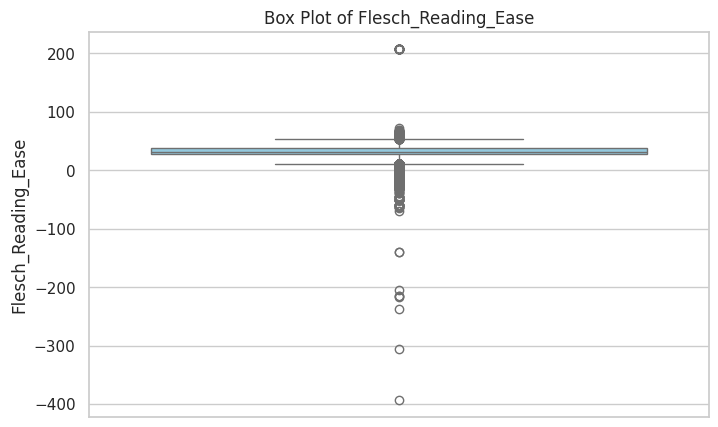

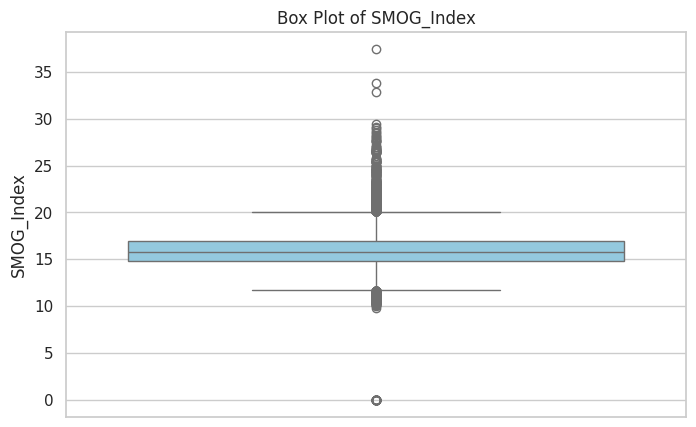

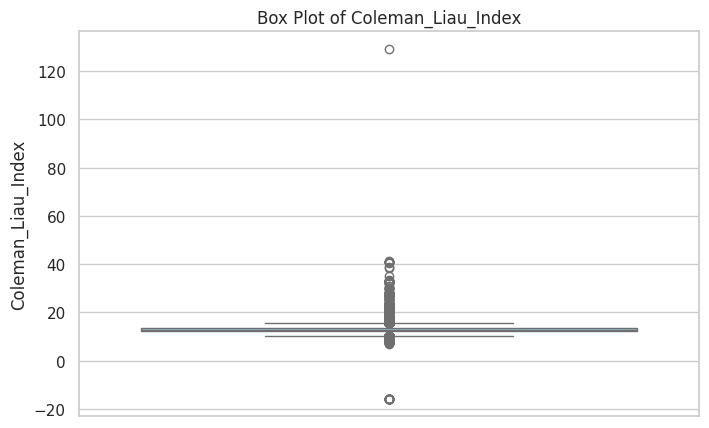

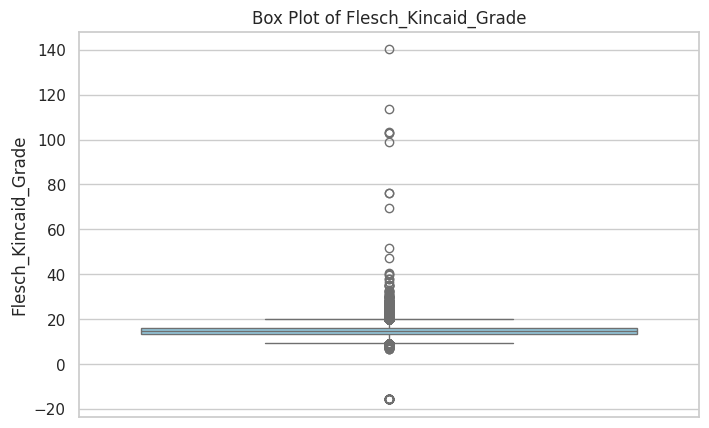

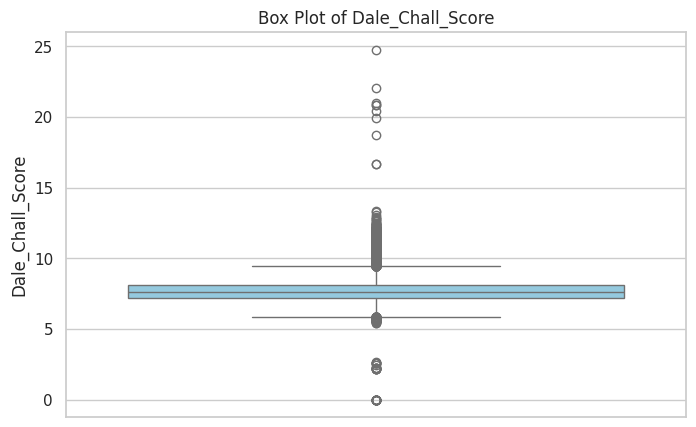

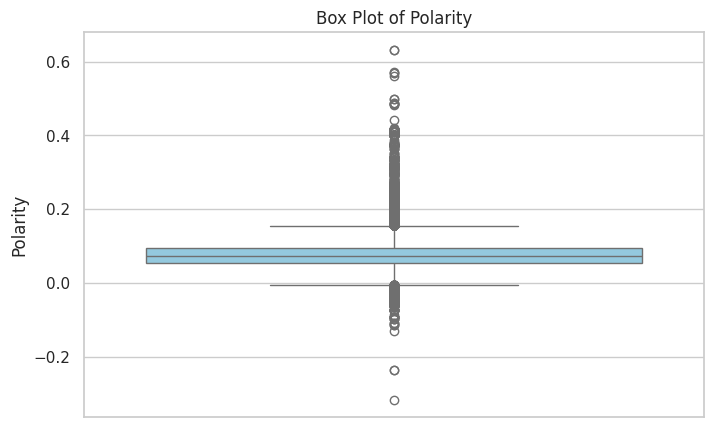

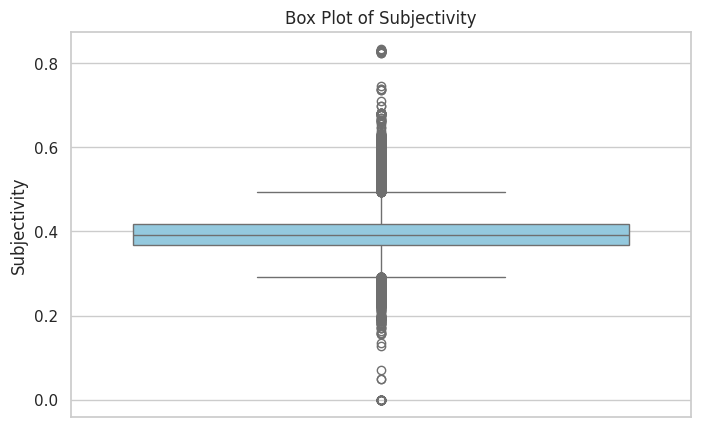

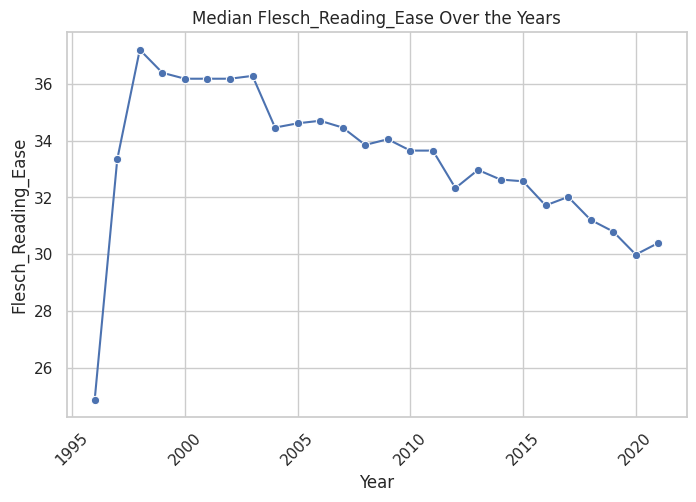

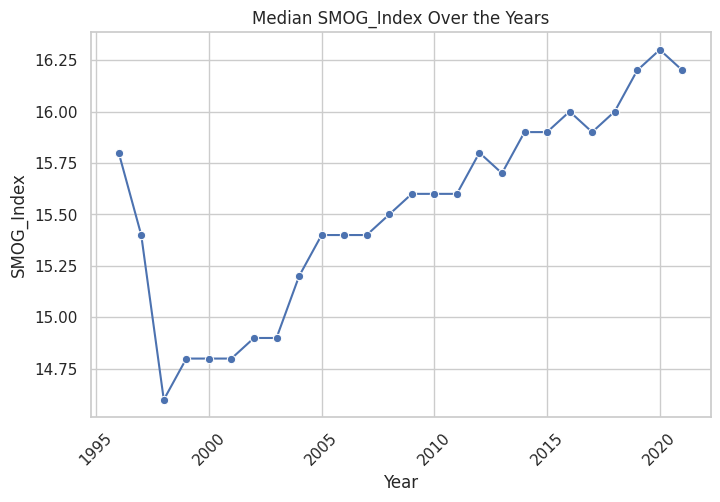

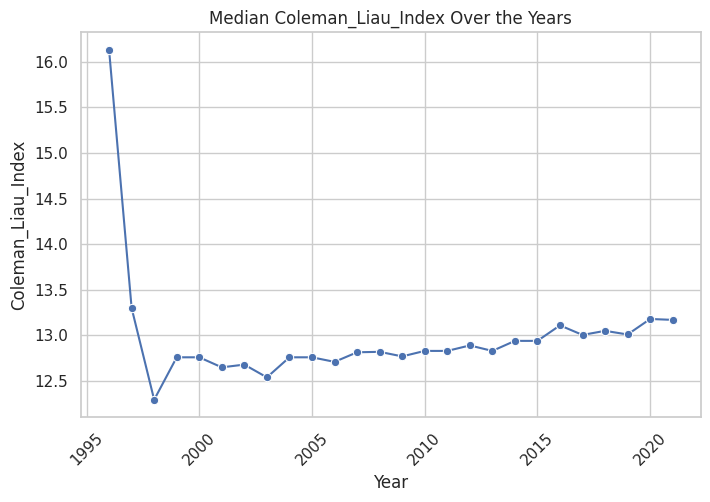

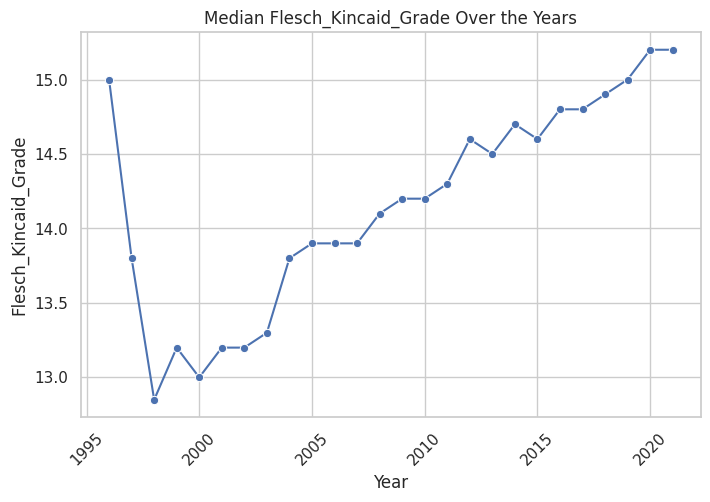

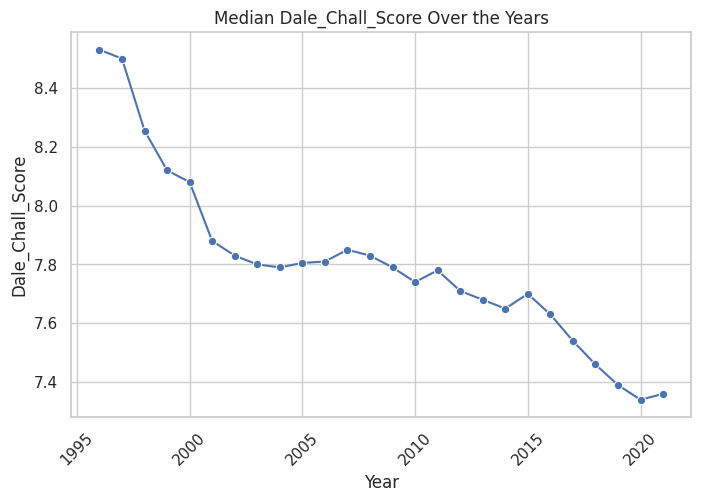

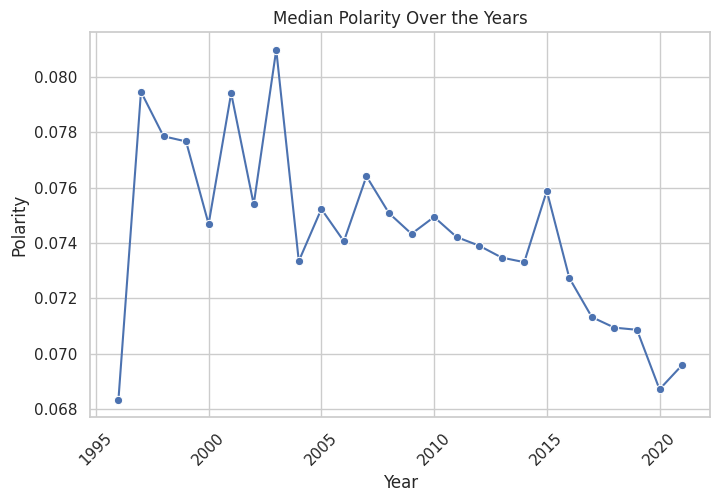

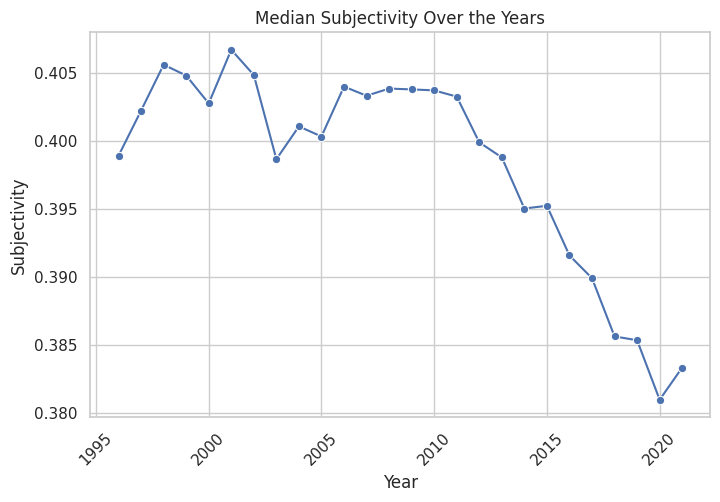


Sentiment analysis and visualizations completed.


In [4]:
#2b
#Load processed dataset from Part (a)
df = pd.read_csv('policy_analysis_sample.csv')

# Preview basic info
print("Dataset shape:", df.shape)
print("Column names:", df.columns)
print(df.head())

#Define policy directory for fallback file loading
policy_dir = '/home3/COMP42315/policy-texts/policies_fromseg_custom/'

#Define sentiment function
def compute_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

#Only load text and compute sentiment if not already present
if 'Polarity' not in df.columns or 'Subjectivity' not in df.columns:
    print("Computing sentiment scores...")

    if 'policy_text' not in df.columns:
        #Load policy text from file if not already present
        df['policy_text'] = df['policy_id'].apply(
            lambda x: open(os.path.join(policy_dir, x + '.txt'), 'r', encoding='utf-8').read()
        )

    #Clean text before analysis
    df['clean_text'] = df['policy_text'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()

    #Apply sentiment function
    df[['Polarity', 'Subjectivity']] = df['clean_text'].apply(lambda x: compute_sentiment(str(x))).apply(pd.Series)

    #Save updated dataset with sentiment
    df.to_csv('policy_analysis_sample_with_sentiment.csv', index=False)
    print("Sentiment computed and saved.")
else:
    print("Sentiment already present in dataset. Skipping recalculation.")

#Sample output
print(df[['policy_id', 'Polarity', 'Subjectivity']].head())

#Boxplots of readability and sentiment metrics
sns.set(style="whitegrid")
metrics_to_plot = ['Flesch_Reading_Ease', 'SMOG_Index', 'Coleman_Liau_Index',
                   'Flesch_Kincaid_Grade', 'Dale_Chall_Score', 'Polarity', 'Subjectivity']

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=df[metric], color='skyblue')
    plt.title(f"Box Plot of {metric}")
    plt.ylabel(metric)
    plt.show()

#Line plots of median trends over time
df['year'] = df['year'].astype(int)
median_trends = df.groupby('year')[metrics_to_plot].median().reset_index()

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=median_trends, x='year', y=metric, marker='o')
    plt.title(f"Median {metric} Over the Years")
    plt.ylabel(metric)
    plt.xlabel("Year")
    plt.xticks(rotation=45)
    plt.show()

print("\nSentiment analysis and visualizations completed.")


 Correlation Matrix:
                      Flesch_Reading_Ease  SMOG_Index  Coleman_Liau_Index  \
Flesch_Reading_Ease              1.000000   -0.761557           -0.755455   
SMOG_Index                      -0.761557    1.000000            0.481061   
Coleman_Liau_Index              -0.755455    0.481061            1.000000   
Flesch_Kincaid_Grade            -0.906141    0.812200            0.506924   
Dale_Chall_Score                -0.278811    0.103564            0.322902   
Polarity                         0.172796   -0.218340            0.018814   
Subjectivity                     0.110816   -0.172225           -0.061504   

                      Flesch_Kincaid_Grade  Dale_Chall_Score  Polarity  \
Flesch_Reading_Ease              -0.906141         -0.278811  0.172796   
SMOG_Index                        0.812200          0.103564 -0.218340   
Coleman_Liau_Index                0.506924          0.322902  0.018814   
Flesch_Kincaid_Grade              1.000000          0.204705 -0.2

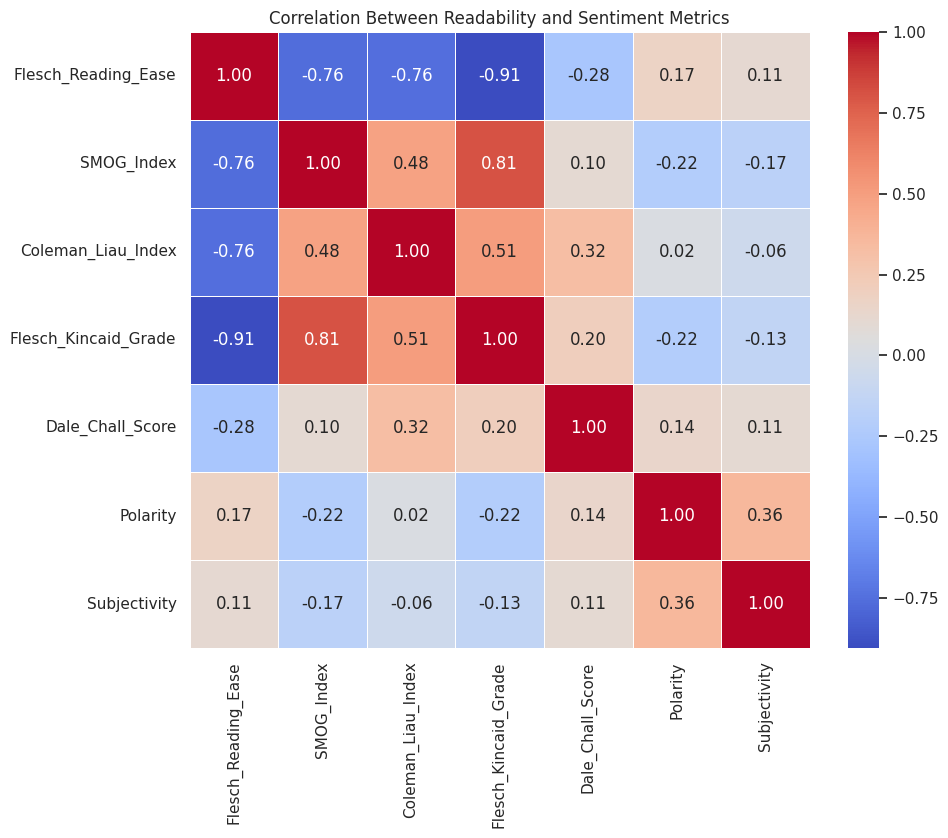

In [5]:
#2c
#Select relevant columns for correlation
readability_metrics = ['Flesch_Reading_Ease', 'SMOG_Index', 'Coleman_Liau_Index',
                       'Flesch_Kincaid_Grade', 'Dale_Chall_Score']
sentiment_metrics = ['Polarity', 'Subjectivity']

#Combine for correlation matrix
correlation_features = readability_metrics + sentiment_metrics
corr_matrix = df[correlation_features].corr()

#Display the correlation matrix
print("\n Correlation Matrix:")
print(corr_matrix)

#Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Readability and Sentiment Metrics")
plt.show()

### Write your text/report in the following space.

After processing all 56,416 privacy policy documents provided in the dataset, I computed five standard readability metrics using textstat, for each policy. This included Flesch Reading Ease, SMOG Index, Coleman-Liau Index, Flesch-Kincaid Grade and Dale-Chall Readability Score. After matching each file to the corresponding entry in the metadata file using its hash, we compared the computed values to the provided metadata. There were slight differences which were consistent and small, indicating that the calculations were reliable. 

For part b, I computed polarity and subjectivity scores for each policy by using TextBlob. After cleaning the text to improve accuracy of sentiment, although many policies displayed a neutral sentiment, there definitely was some variation across the set of data. I created boxplots to visualize overall distributions, and then computed median values per year, plotting trends over time. Readability metrics had minor variation, sentiment remained neutral and subjectivity had some shifts. 

Later, I assessed the potential relationships between the computed readability metrics and sentiment scores. I then visualized it through a heatmap which showed weak to no correlation between readability and sentiment metrics. A privacy policy’s readability therefore does not necessarily mpact the emotional tone or subjectivity. The overall correlation results give strength to the logic that readability and sentiment are independent aspects of a policy’s language.

My analysis provided insights into the way policies are written, their readability, and neutral in nature. 


# Question 3 (35 marks)

For this question, you are asked to perform the task based on the target dataset (drone.csv), which you can download separately on Blackboard Ultra. The target drone dataset contains different features related to the drone physical attributes.  The target variable is 'warning', i.e. warning level. If the warning  level is high then a drone must be grounded immediately to avoid any damage to the drone itself as well as the surroundings (in case of a crash). Design and implement the solution to use data analysis and visualisation for the following tasks: [35%]

a) You are required to extract a subset that includes the 'defined_features' and the 'target_variable' (in the subset, there will be 11 features in total including target variable). You are required to extract the 'defined_features' that are as indicated below: 

defined_features = ['voltage_v', 'voltage_filtered_v', 'current_a', 'current_filtered_a', 'discharged_mah', 'remaining', 'scale', 'load', 'ram_usage'] 

Perform exploratory data analysis on the drone dataset ('defined_features'), highlight the features that are statistically important and highly correlated to the 'target variable', and visualise them legibly using an appropriate visual method. Save the statistically important features as a subset 'selected_features' and compare them with the 'defined_features'. Highlight any differences and report your findings. [10/35]

b) Perform analysis to identify the complex relationship between drone physical attributes ('selected_features') and the warning level ('target_variable') using a probabilistic method. Highlight and visualise the attributes with the highest probabilistic relationship with the target variable. Justify the design choice and showcase the findings using an appropriate visualisation tool. [18/35]

c) Perform predictive analysis using at least one machine learning algorithms and validate its performance based on suitable performance metrics. Justify the design choice and showcase the findings using an appropriate visualisation tool. [7/35]

[Explain your design and highlight any features in this question's report part of your Jupyter Notebook in no more than 400 words.]

### Write your code in the following space.


< Summary Statistics >
         voltage_v  voltage_filtered_v    current_a  current_filtered_a  \
count  5725.000000         5725.000000  5725.000000         5725.000000   
mean     17.996774           18.013255    16.099150           16.083609   
std       1.980443            1.948583     5.380619            5.363591   
min      14.276200           16.118723     0.124000            0.171426   
25%      16.990400           17.034609    17.037600           17.101912   
50%      17.293800           17.250465    18.054400           18.075237   
75%      17.802200           17.703796    18.810800           18.788374   
max      23.829200           23.832287    22.220800           21.309430   

       discharged_mah    remaining        scale         load    ram_usage  \
count     5725.000000  5725.000000  5725.000000  5724.000000  5724.000000   
mean       568.838936     0.081593     1.143835     0.708155     0.855029   
std        602.918011     0.230874     0.037450     0.009810     0.00

/tmp/ipykernel_3926128/1803222670.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


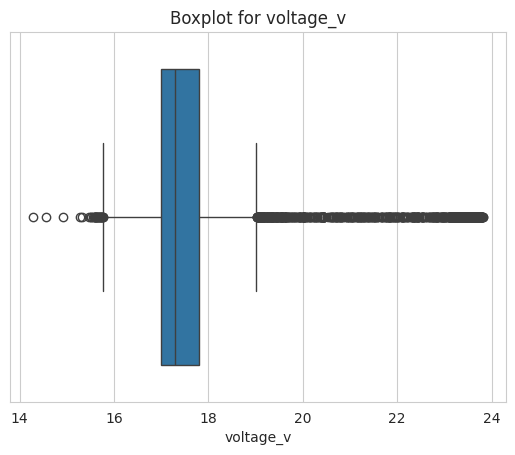

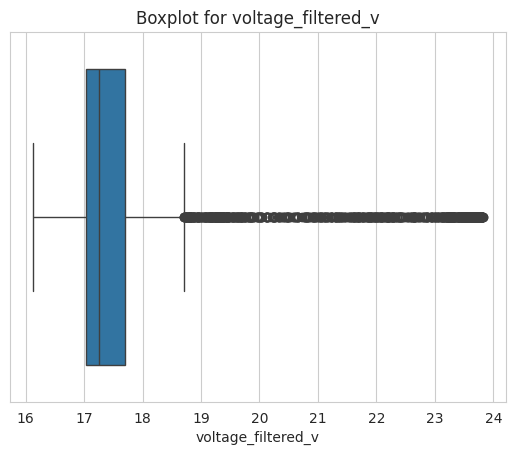

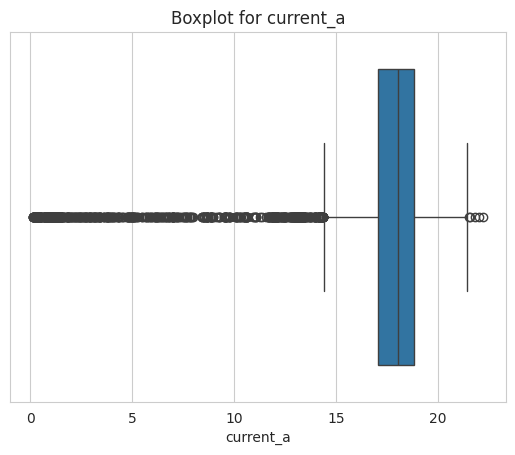

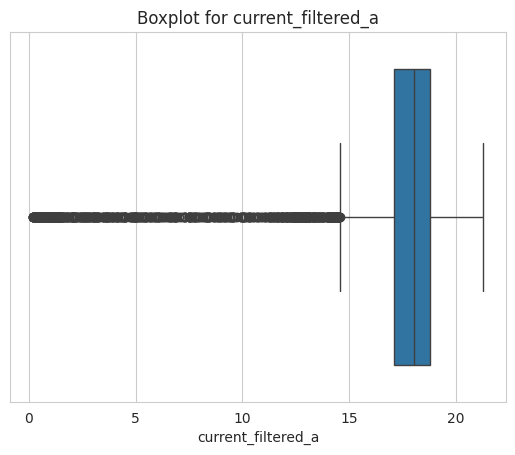

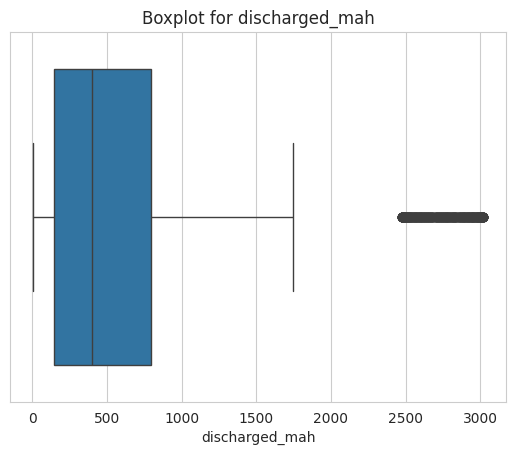

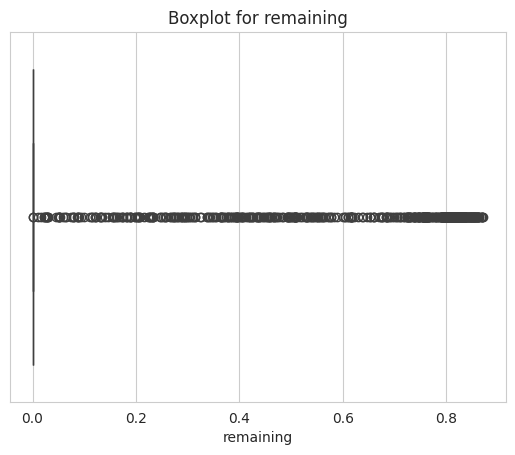

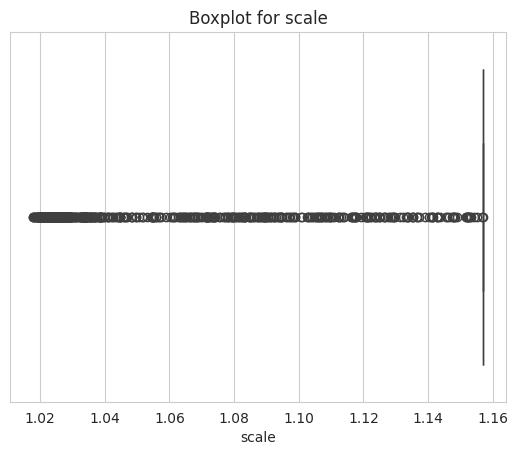

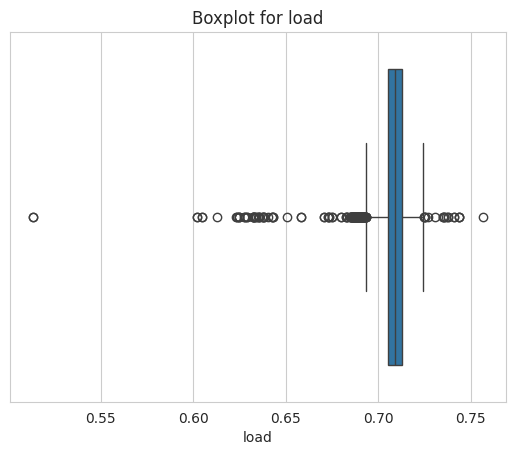

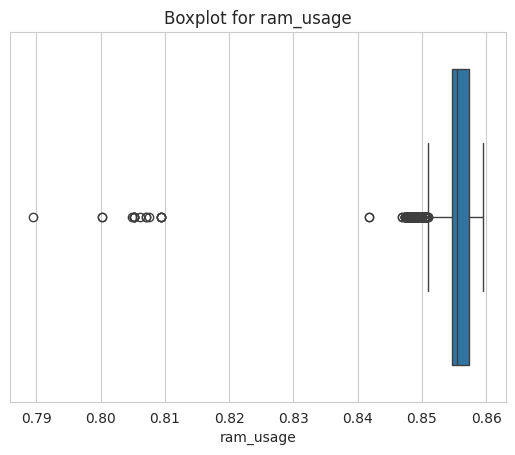

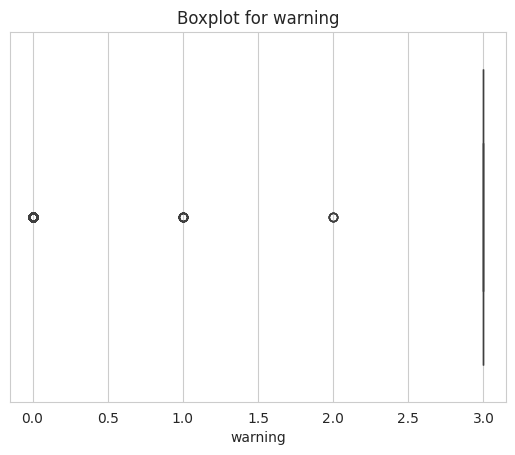

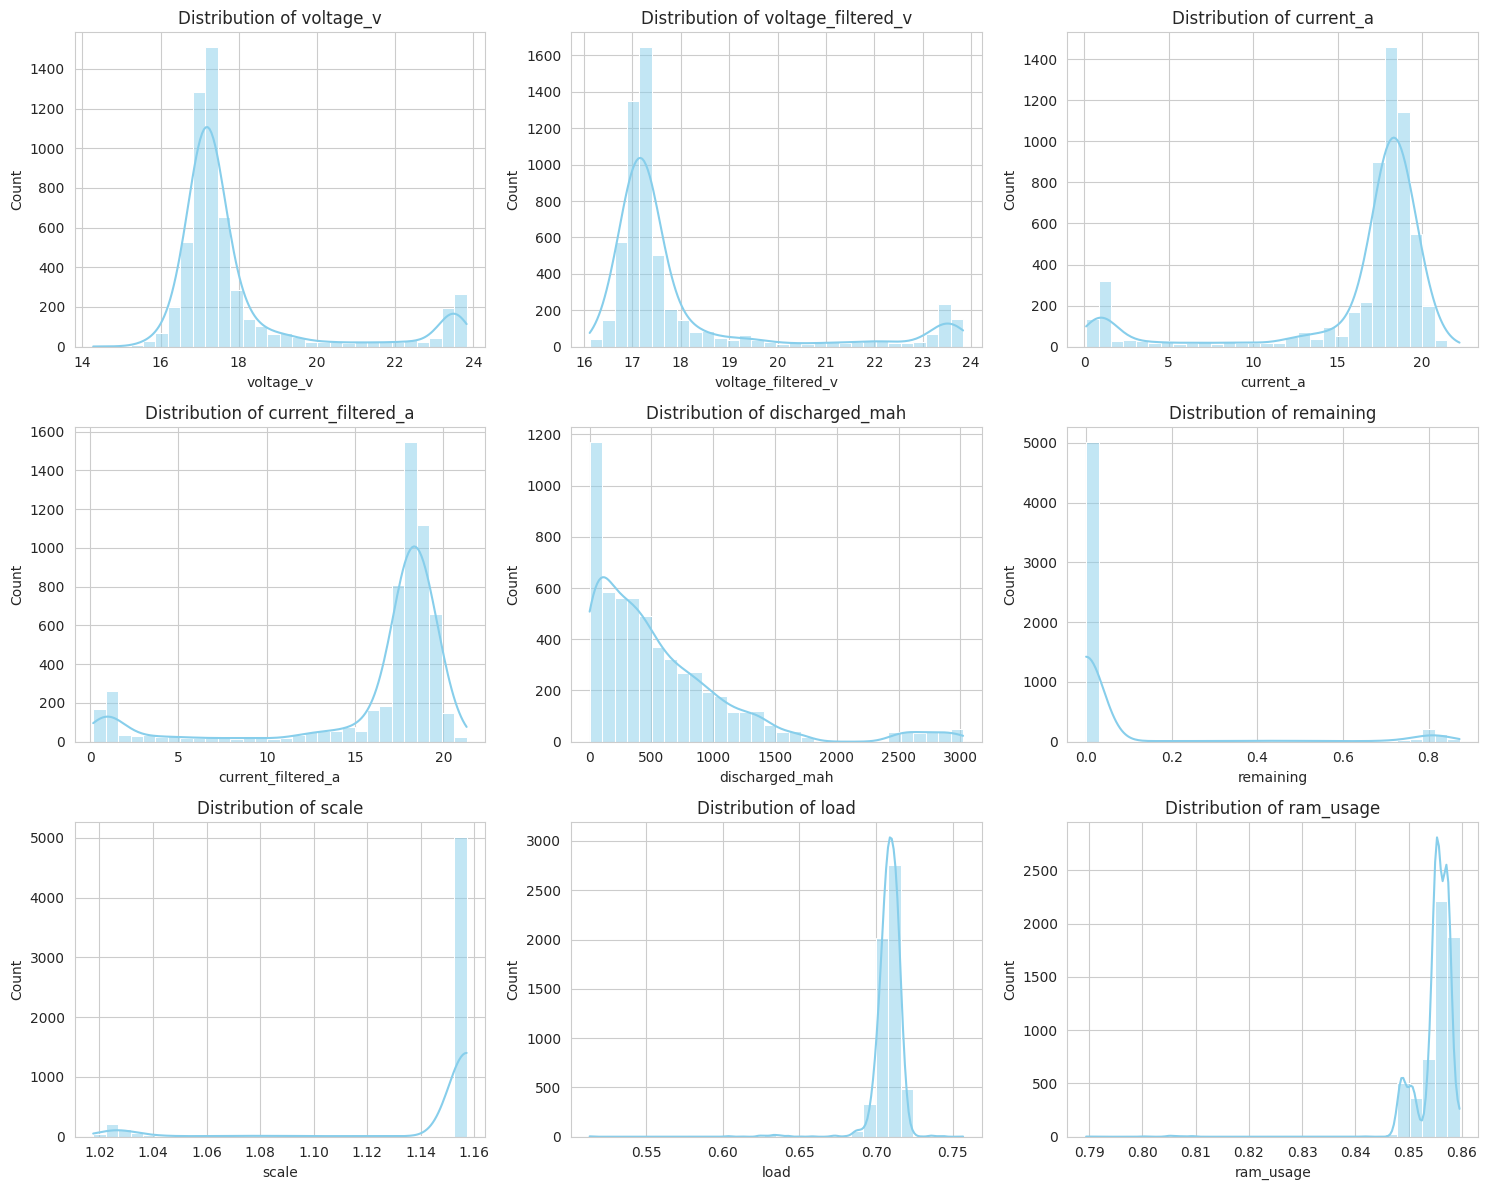

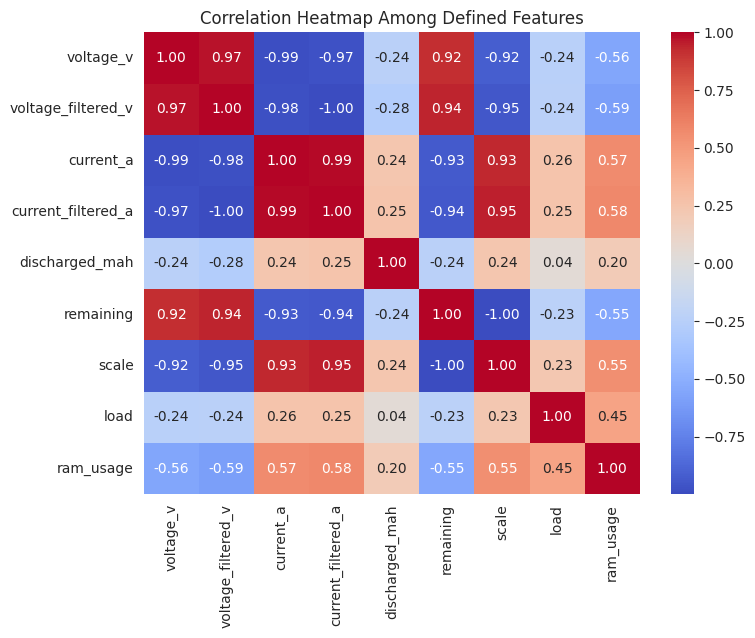


< Correlation Coefficients with Target Variable >
voltage_v            -0.858316
voltage_filtered_v   -0.908926
current_a             0.872333
current_filtered_a    0.895547
discharged_mah        0.269458
remaining            -0.942441
scale                 0.944046
load                  0.181124
ram_usage             0.562312
dtype: float64


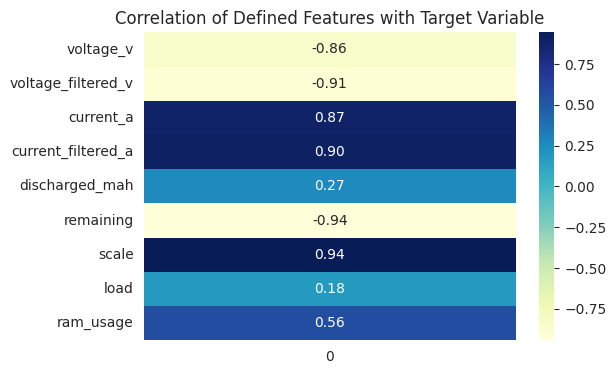

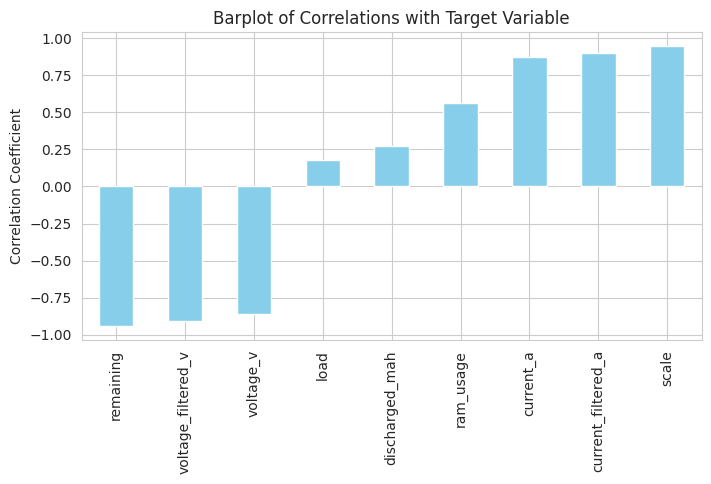


< Selected Features (|correlation| > 0.75) >
['voltage_v', 'voltage_filtered_v', 'current_a', 'current_filtered_a', 'remaining', 'scale']

< Features in Defined Features but not Selected >
{'ram_usage', 'load', 'discharged_mah'}

< Subset with Selected Features >
   voltage_v  voltage_filtered_v  current_a  current_filtered_a  remaining  \
0  23.821001           23.832287     0.1612            0.231098   0.868972   
1  23.681600           23.805693     0.4464            0.261076   0.872252   
2  23.583200           23.732930     0.8680            0.530416   0.857639   
3  23.534000           23.650160     0.9176            0.848289   0.837432   
4  23.566800           23.614992     0.9176            0.879427   0.829972   

      scale  warning  
0  1.018116        0  
1  1.017655        0  
2  1.019714        0  
3  1.022576        0  
4  1.023636        0  


In [41]:
#All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar
from bokeh.layouts import layout
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import networkx as nx
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score
from IPython.core.display import display, HTML
import tabulate as tb

#3a
#Loading dataset and extracting the defined features and target variable
df = pd.read_csv('drone.csv')
defined_features = ['voltage_v', 'voltage_filtered_v', 'current_a', 'current_filtered_a', 
                    'discharged_mah', 'remaining', 'scale', 'load', 'ram_usage']
target_variable = 'warning'
subset_columns = defined_features + [target_variable]
df_subset = df[subset_columns]

#Create summary statistics for defined features and target variable
print("\n< Summary Statistics >")
print(df_subset.describe())

#Make boxplots to detect outliers for each variable
for col in defined_features + [target_variable]:
    plt.figure()
    sns.boxplot(x=df_subset[col])
    plt.title(f"Boxplot for {col}")
    plt.xlabel(col)
    plt.show()

#Distributions for Defined_features
import matplotlib.pyplot as plt
import seaborn as sns

#Number of features
num_features = len(defined_features)
cols = 3  # Fixed number of columns
rows = (num_features // cols) + (num_features % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))

#Axes flattened
axes = axes.flatten()

#Looping through each feature and plotting its histogram
for i, col in enumerate(defined_features):
    sns.histplot(df_subset[col], bins=30, kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)

#Hiding extras
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

#Correlation among the defined features
corr_defined = df_subset[defined_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_defined, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap Among Defined Features")
plt.show()

#Correlation coeffs between defined features and target variable correlation
corr_with_target = df_subset[defined_features].corrwith(df_subset[target_variable])
print("\n< Correlation Coefficients with Target Variable >")
print(corr_with_target)

#Heatmap correlation visualisation
plt.figure(figsize=(6,4))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation of Defined Features with Target Variable")
plt.show()

#Barplot correlation visualisation
plt.figure(figsize=(8,4))
corr_with_target.sort_values().plot(kind='bar', color='skyblue')
plt.ylabel("Correlation Coefficient")
plt.title("Barplot of Correlations with Target Variable")
plt.show()

#Use a threshold of 0.75 to filter out selected features
threshold = 0.75
selected_features = list(corr_with_target[abs(corr_with_target) > threshold].index)
print("\n< Selected Features (|correlation| > {:.2f}) >".format(threshold))
print(selected_features)

#Comparing selected features with defined features
diff_features = set(defined_features) - set(selected_features)
print("\n< Features in Defined Features but not Selected >")
print(diff_features)

#Saving a new subset with important features
df_selected = df_subset[selected_features + [target_variable]]
print("\n< Subset with Selected Features >")
print(df_selected.head())

Columns in selected_and_target: Index(['voltage_v', 'voltage_filtered_v', 'current_a', 'current_filtered_a',
       'remaining', 'scale', 'warning'],
      dtype='object')
[{'voltage_v': '1. Less than: 15', 'Count': 525}, {'voltage_v': '2. Between: 15 and 17', 'Count': 4342}, {'voltage_v': '3. Between: 17 and 21', 'Count': 241}, {'voltage_v': '4. Greater than: 21', 'Count': 617}]
[{'voltage_filtered_v': '1. Less than: 15', 'Count': 4543}, {'voltage_filtered_v': '2. Between: 15 and 17', 'Count': 447}, {'voltage_filtered_v': '3. Between: 17 and 21', 'Count': 161}, {'voltage_filtered_v': '4. Greater than: 21', 'Count': 574}]
[{'current_a': '1. Less than: 15', 'Count': 588}, {'current_a': '2. Between: 15 and 17', 'Count': 143}, {'current_a': '3. Between: 17 and 21', 'Count': 588}, {'current_a': '4. Greater than: 21', 'Count': 4406}]
[{'current_filtered_a': '1. Less than: 15', 'Count': 589}, {'current_filtered_a': '2. Between: 15 and 17', 'Count': 138}, {'current_filtered_a': '3. Between: 1

  0%|          | 0/30 [00:00<?, ?it/s]


< Learned Bayesian Network Structure (Edges) >
[('voltage_v', 'current_a'), ('voltage_filtered_v', 'warning'), ('voltage_filtered_v', 'current_a'), ('voltage_filtered_v', 'voltage_v'), ('voltage_filtered_v', 'current_filtered_a'), ('warning', 'current_a'), ('warning', 'voltage_v'), ('warning', 'current_filtered_a'), ('current_filtered_a', 'current_a'), ('current_filtered_a', 'voltage_v'), ('remaining', 'scale'), ('remaining', 'current_a'), ('remaining', 'warning'), ('remaining', 'voltage_v'), ('remaining', 'voltage_filtered_v'), ('remaining', 'current_filtered_a'), ('scale', 'current_a'), ('scale', 'warning'), ('scale', 'voltage_v'), ('scale', 'voltage_filtered_v'), ('scale', 'current_filtered_a')]


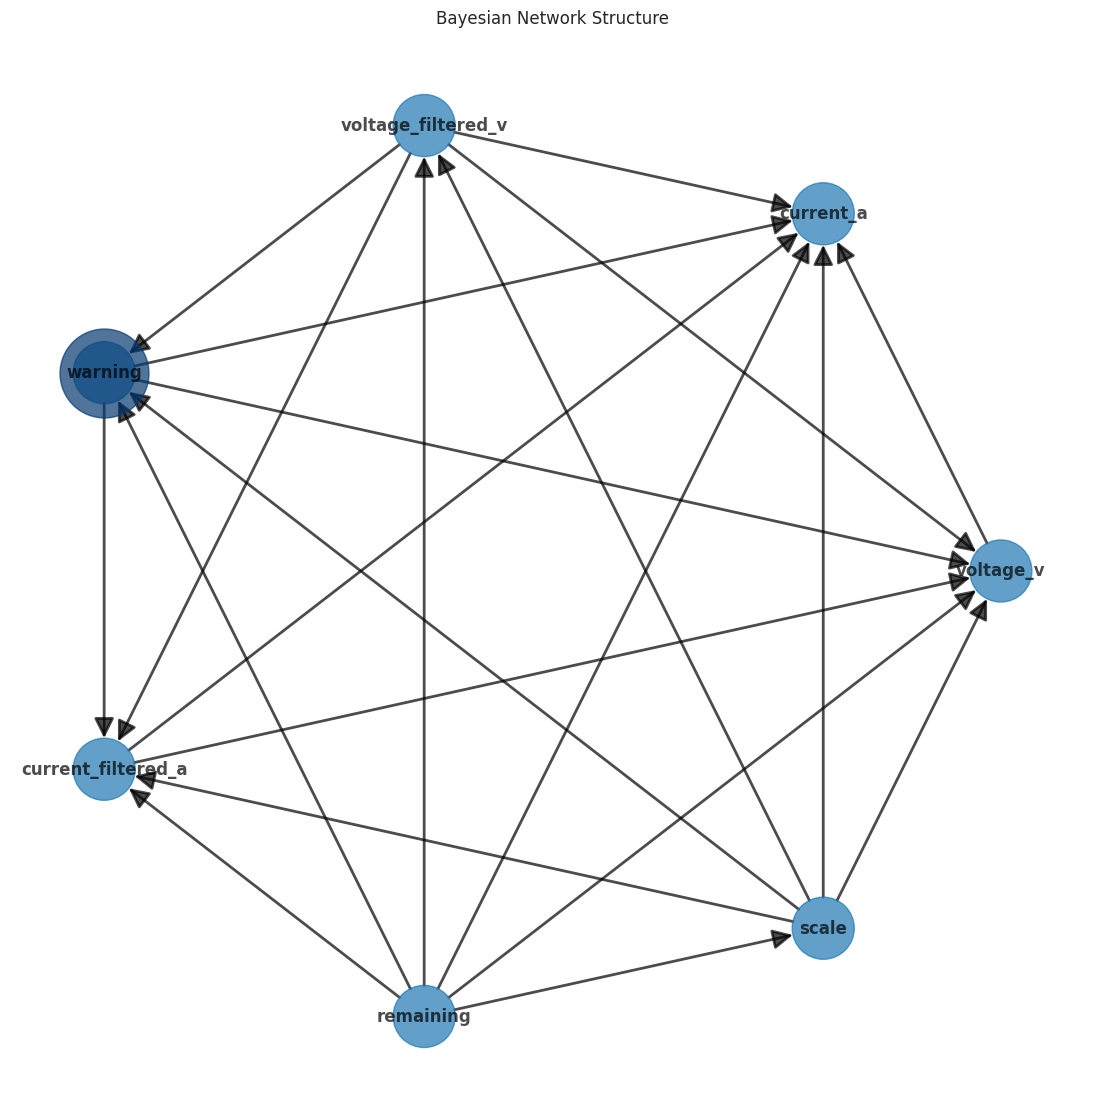

  0%|          | 0/33 [00:00<?, ?it/s]

voltage_v Accuracy score: 0.879475982532751


  0%|          | 0/33 [00:00<?, ?it/s]

voltage_filtered_v Accuracy score: 0.9764192139737992


  0%|          | 0/33 [00:00<?, ?it/s]

current_a Accuracy score: 0.9615720524017467


  0%|          | 0/35 [00:00<?, ?it/s]

current_filtered_a Accuracy score: 0.9790393013100437


  0%|          | 0/39 [00:00<?, ?it/s]

remaining Accuracy score: 0.994759825327511


  0%|          | 0/36 [00:00<?, ?it/s]

scale Accuracy score: 0.988646288209607


  0%|          | 0/34 [00:00<?, ?it/s]

warning Accuracy score: 0.9860262008733625

< Accuracy Scores from BN Evaluation >


{'voltage_v': 0.879475982532751,
 'voltage_filtered_v': 0.9764192139737992,
 'current_a': 0.9615720524017467,
 'current_filtered_a': 0.9790393013100437,
 'remaining': 0.994759825327511,
 'scale': 0.988646288209607,
 'warning': 0.9860262008733625,
 'Average': 0.9665626949469744}


F1 score: 0.0
Accuracy score: 1.0
Precision score: 0.0
Recall score: 0.0
Log-likelihood score: -1674.2341019142223
Structure score: -1937.3652106766838

Model Name:


Model Check: True
Check model: True

CPT of voltage_v:
+----------------------------------+-----+
| current_filtered_a               | ... |
+----------------------------------+-----+
| remaining                        | ... |
+----------------------------------+-----+
| scale                            | ... |
+----------------------------------+-----+
| voltage_filtered_v               | ... |
+----------------------------------+-----+
| warning                          | ... |
+----------------------------------+-----+
| voltage_v(1. Less than: 15)      | ... |
+----------------------------------+-----+
| voltage_v(2. Between: 15 and 17) | ... |
+----------------------------------+-----+
| voltage_v(3. Between: 17 and 21) | ... |
+----------------------------------+-----+
| voltage_v(4. Greater than: 21)   | ... |
+--

/apps/jupyterhub/COMP42315/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/apps/jupyterhub/COMP42315/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/apps/jupyterhub/COMP42315/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+----------------------------------+-----+
| current_filtered_a               | ... |
+----------------------------------+-----+
| remaining                        | ... |
+----------------------------------+-----+
| scale                            | ... |
+----------------------------------+-----+
| voltage_filtered_v               | ... |
+----------------------------------+-----+
| voltage_v                        | ... |
+----------------------------------+-----+
| warning                          | ... |
+----------------------------------+-----+
| current_a(1. Less than: 15)      | ... |
+----------------------------------+-----+
| current_a(2. Between: 15 and 17) | ... |
+----------------------------------+-----+
| current_a(3. Between: 17 and 21) | ... |
+----------------------------------+-----+
| current_a(4. Greater than: 21)   | ... |
+----------------------------------+-----+ 

CPT of voltage_filtered_v:
+-----+---------------------------------+
| ... | remaining(4. Great

In [42]:
#3b
#For BN modelling, I will discretise the continuous variables and discretise selected feature into 4 bins and target variable into 4 bins
df_selected.describe().transpose()
selected_and_target = df_selected.copy()
print("Columns in selected_and_target:", selected_and_target.columns)
selected_and_target.head()
selected_and_target.describe().transpose()

#Create labels
voltage_v_labels = ['1. Less than: 15', '2. Between: 15 and 17', '3. Between: 17 and 21', '4. Greater than: 21']
voltage_filtered_v_labels = ['1. Less than: 15', '2. Between: 15 and 17', '3. Between: 17 and 21', '4. Greater than: 21']
current_a_labels = ['1. Less than: 15', '2. Between: 15 and 17', '3. Between: 17 and 21', '4. Greater than: 21']
current_filtered_a_labels = ['1. Less than: 15', '2. Between: 15 and 17', '3. Between: 17 and 21', '4. Greater than: 21']
remaining_labels = ['1. Less than: 0.2', '2. Between: 0.2 and 0.4', '3. Between: 0.4 and 0.8', '4. Greater than: 0.8']
scale_labels = ['1. Less than: 0.3', '2. Between: 0.3 and 0.6', '3. Between: 0.6 and 0.9', '4. Greater than: 0.9']
ram_usage_labels = ['1. Less than: 0.850', '2. Between: 0.850 and 0.855', '3. Between: 0.855 and 0.860', '4. Greater than: 0.860']
warning_labels = ['1. 0', '2. 1', '3. 2', '4. 3']

#Perform discretization
def make_discrete(selected_and_target):
    discrete_drone = pd.DataFrame()
    discrete_drone['voltage_v'] = pd.cut(selected_and_target['voltage_v'], bins=4, labels=voltage_v_labels, precision=2)
    discrete_drone['voltage_filtered_v'] = pd.cut(selected_and_target['voltage_filtered_v'], bins=4, labels=voltage_filtered_v_labels, precision=2)
    discrete_drone['current_a'] = pd.cut(selected_and_target['current_a'], bins=4, labels=current_a_labels, precision=2)
    discrete_drone['current_filtered_a'] = pd.cut(selected_and_target['current_filtered_a'], bins=4, labels=current_filtered_a_labels, precision=2)
    discrete_drone['remaining'] = pd.cut(selected_and_target['remaining'], bins=4, labels=remaining_labels, precision=2)
    discrete_drone['scale'] = pd.cut(selected_and_target['scale'], bins=4, labels=scale_labels, precision=2)
    discrete_drone['warning'] = pd.cut(selected_and_target['warning'], bins=4, labels=warning_labels, precision=2)

    discrete_drone = discrete_drone.astype('object')
    return discrete_drone

#Function to perform discretization
cat_dd = make_discrete(selected_and_target)
cat_dd.head(5)
for col in cat_dd:
    print(cat_dd.groupby(col)[col].count().reset_index(name='Count').to_dict(orient='records'))

#Discretised data split into 80% train and 20% test
print("Columns in selected_and_target before discretization:", selected_and_target.columns)
df_bn = make_discrete(selected_and_target)
print(df_bn.head())
train_data, test_data = train_test_split(df_bn, test_size=0.2, random_state=42)

#K2 scoring method will be used using HCS on the BN structure
hc = HillClimbSearch(train_data)
best_model = hc.estimate(scoring_method='k2score', max_iter = 30, show_progress=True)
bn_model = BayesianNetwork(best_model.edges())
print("\n< Learned Bayesian Network Structure (Edges) >")
print(bn_model.edges())

#Fitting the BN using the training data with a Bayesian Estimator
display(HTML("<style>div.output_area pre {white-space: pre;} </style>"))
bn_model.cpds = []
bn_model.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

#Networkx to visualise the BN
plt.figure(3,figsize=(14,14))
G = nx.DiGraph()
G.add_edges_from(bn_model.edges())
G.add_nodes_from(bn_model.nodes())
pos = nx.circular_layout(G)
DAG = G.to_directed()
nx.topological_sort(DAG)
nx.draw_networkx(G, pos=pos, with_labels=True, node_size=[2000, 2000, 2000, 2000, 2000, 2000, 2000], arrowsize=30, alpha=0.7, font_weight="bold", width=2.0)
tt_g = G.subgraph(nodes=['warning'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color='#063970')
plt.title("Bayesian Network Structure")
plt.show()

#Collecting prediction accuracy score for all variables
accuracy_dict = {}

for col in test_data:
    predict_data = test_data.copy()
    predict_data.drop(col, axis=1, inplace=True)
    y_pred = bn_model.predict(predict_data)
    if col in y_pred.columns:
        col_accuracy = accuracy_score(test_data[col], y_pred[col])
        print(f"{col} Accuracy score: {col_accuracy}")
        accuracy_dict[col] = col_accuracy

avg_accuracy = sum(accuracy_dict.values()) / len(accuracy_dict)
accuracy_dict['Average'] = avg_accuracy
print("\n< Accuracy Scores from BN Evaluation >")
display(accuracy_dict)

#Structure correlation scores
f1_val = correlation_score(model=bn_model, data=test_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc_val = correlation_score(model=bn_model, data=test_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
prec_val = correlation_score(model=bn_model, data=test_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
rec_val = correlation_score(model=bn_model, data=test_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ll_val = log_likelihood_score(model=bn_model, data=test_data)
ss_val = structure_score(model=bn_model, data=test_data, scoring_method='bdeu')

print(f"\nF1 score: {f1_val}")
print(f"Accuracy score: {acc_val}")
print(f"Precision score: {prec_val}")
print(f"Recall score: {rec_val}")
print(f"Log-likelihood score: {ll_val}")
print(f"Structure score: {ss_val}")

print("\nModel Name:")
print(bn_model.name)
print("\nModel Check:", bn_model.check_model())

#CPT
print(f'Check model: {bn_model.check_model()}\n')
for cpd in bn_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd * 100, '\n')


< Random Forest Classifier Performance >
Accuracy: 0.9982532751091703
Confusion Matrix:
[[ 121    0    0    0]
 [   0    3    0    0]
 [   0    0    2    0]
 [   2    0    0 1017]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       121
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00      1019

    accuracy                           1.00      1145
   macro avg       1.00      1.00      1.00      1145
weighted avg       1.00      1.00      1.00      1145



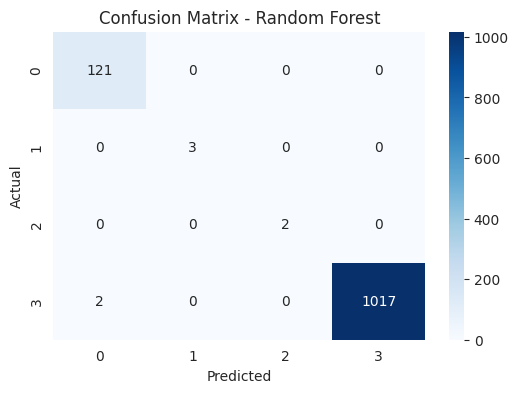

In [43]:
#3c
#Will do predictive analysis, for which the original selected features will be used
X = df_selected[selected_features]
y = df_selected[target_variable]

#In case the target variable is not numeric, i will factorise it
if not np.issubdtype(y.dtype, np.number):
    y, _ = pd.factorize(y)

#80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Use StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Use RandomForestClassifier for predictive analysis
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

#Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\n< Random Forest Classifier Performance >")
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_mat)
print("Classification Report:")
print(class_report)

#Visualise the confusion matrix using a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Write your text/report in the following space.

I conducted exploratory data analysis on the dataset. It contains 9 physical attributes ‘defined_features’ and a target variable ‘warning’. I, then created a subset with these attributes and generated a summary statistics to figure out how data was distributed. I use boxplots because it could detect outliers. Voltage_v and current_a had extreme values.

Following this, I performed a correlation analysis and measured the relationship between features and the warning level. For this I used a heatmap and a bar chart and identified features with an absolute correlation above 0.75 as significant statistically. Selected_features was the subset which was compared to defined_features and it highlighted differences in the importance of all the features. Finally, I did filtering and included only the relevant attributes.

I used Bayesian Network for probabilistic modelling because they capture conditional relationships between variables. I did it by discretizing continuous features into four bins. I also used Hill Climb Search to learn the structure of the network and computed Conditional Probability Tables through Bayesian Estimation. The Bayesian Network visualization revealed that features like voltage_v, current_a, remaining and warning have strong dependencies and the CPTs gave good insights into how if the attributes vary, they can have an effect on warning levels.

I used Random Forest for predictive analysis to predict warning levels. I used the selected_features subset which was split into a training and testing of 80% and 20%. To normalize the values, I used StandardScaler. This model achieved high accuracy and confirmed that non-linear approach is ideal to predict warning levels. It is also less sensitive to outliers and missing data. I could have used logistic regression but I believe that Random Forest was effective and proved to be robust.

The exploratory data analysis proved to be effective in selection of features, Bayesian Networks gave me a thorough probabilistic analysis and Random Forest gave predictions with strong accuracy. 